# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). 

#Requirements

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━

#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing. 

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [7]:
# Set niose factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [15]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [8]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [16]:
ENCODING_DIM = 256 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [17]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

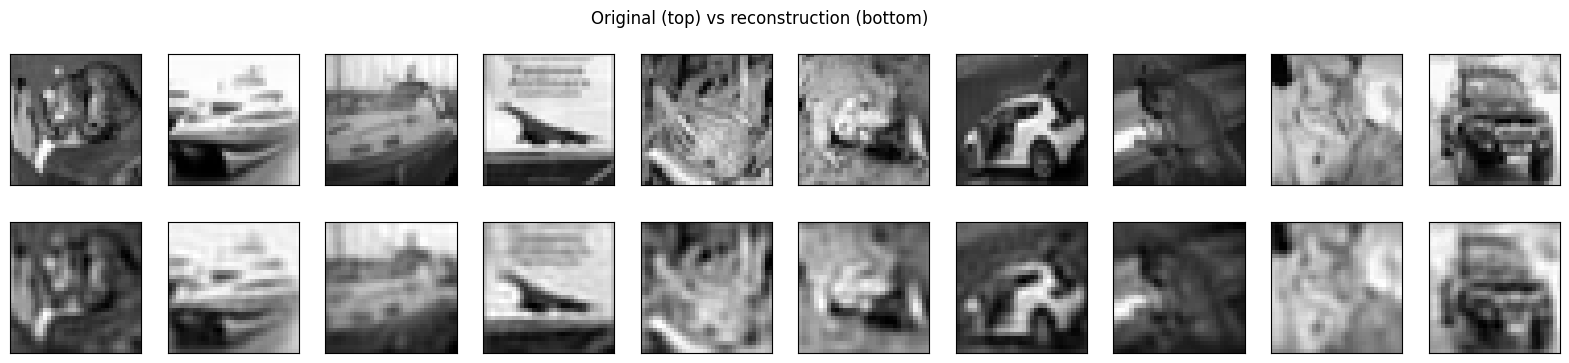

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**:

When you choose only few most important features (we have 1024 features), for example setting `ENCODING_DIM=10`, we only see blurry images where nothing is obvious. So, we conclude that 10 dimensions is a very low dimension to be able to capture the most important features of these photos.

On the other hand, setting the encoding dimension high enough, for example `ENCODING_DIM=900`, the reconstructed image is almost indistinguishable from the original image. But, now the compression is now meaningless because we used almost all features. Here we conclude that setting high dimension for encoding is not a good idea.

The final goal of autoencoder is to capture the most important feature while try not to lose valuable data. This can be done by setting `ENCODING_DIM` to `256` (I chose this so that it can be comparable to the autoencoder of the next section). In 256 dimension, the reconstructed image is sharp enough that we can understand what is on the image whereas only keeps the highly important features.

`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.2 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [19]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition. 

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [10]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.92486787 ---------------- Val_Acc: Val_Loss: 0.25874200
epoch: 2 -> Loss: 0.19424762 ---------------- Val_Acc: Val_Loss: 0.15307187
epoch: 3 -> Loss: 0.12507294 ---------------- Val_Acc: Val_Loss: 0.10589935
epoch: 4 -> Loss: 0.08952080 ---------------- Val_Acc: Val_Loss: 0.07885297
epoch: 5 -> Loss: 0.06823194 ---------------- Val_Acc: Val_Loss: 0.06145451
epoch: 6 -> Loss: 0.05417832 ---------------- Val_Acc: Val_Loss: 0.04971108
epoch: 7 -> Loss: 0.04429491 ---------------- Val_Acc: Val_Loss: 0.04124626
epoch: 8 -> Loss: 0.03721224 ---------------- Val_Acc: Val_Loss: 0.03490646
epoch: 9 -> Loss: 0.03182388 ---------------- Val_Acc: Val_Loss: 0.03002633
epoch: 10 -> Loss: 0.02757098 ---------------- Val_Acc: Val_Loss: 0.02628181
epoch: 11 -> Loss: 0.02419363 ---------------- Val_Acc: Val_Loss: 0.02330100
epoch: 12 -> Loss: 0.02146814 ---------------- Val_Acc: Val_Loss: 0.02084269
epoch: 13 -> Loss: 0.01921233 ---------------- Val_Acc: Val_Loss: 0.01872376
epoch: 1

In [11]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

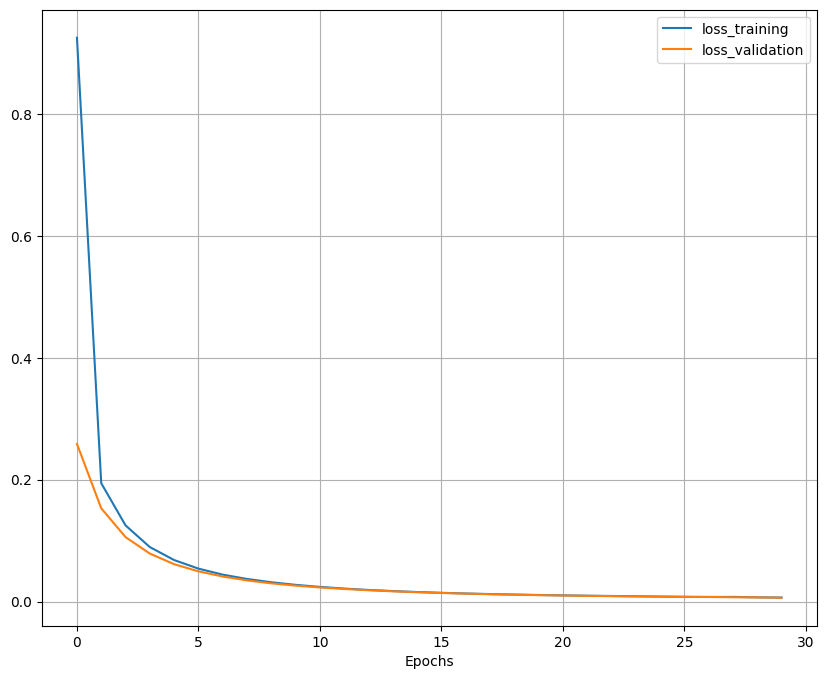

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [20]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00642724


In [13]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

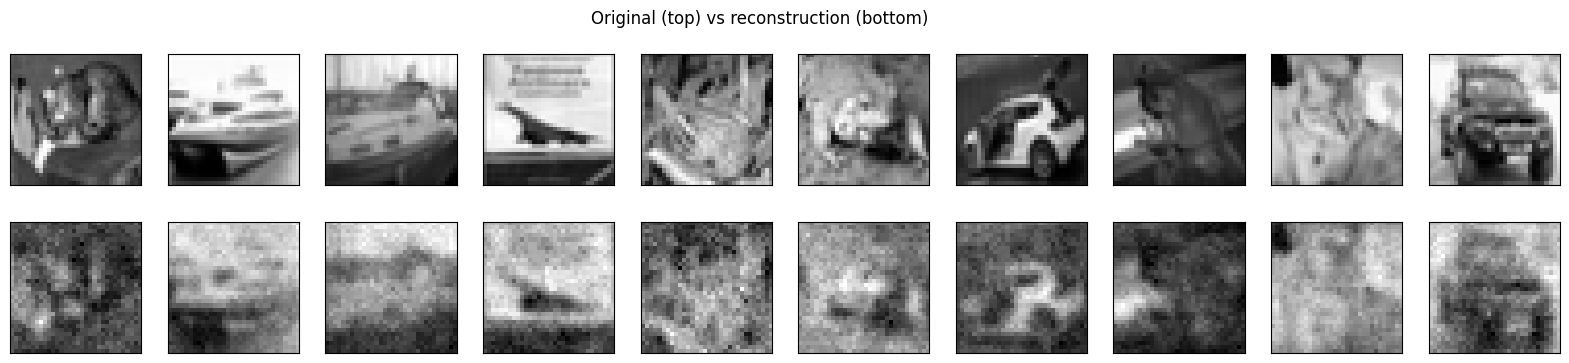

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:

Theoretically speaking, given long enough training time and same size latent layer, we expect both the SVD and linear autoencoder to reach an identical answer. However, in practice situation may not be as we expect. 

After training for 30 epochs and latent layer of size 256 for both the linear autoencoder and the SVD, autoencoder achieved MSE loss of `0.006` whereas SVD reached about `0.002`. 

Comparing the reconstruction images, although they both captured the essential part of the picture and the reconstructed image is distinguishable by human eye, we see that in linear autoencoder, the reconstructed images are more noisy than of SVD. One reason could be the effect of batches. For training, we use batches of 512 images and the gradient is computed using the loss of this 512 images, and then backpropagated. As the loss function may have other local minima, the stochasticity of gradient computation may have put it in a wrong minimum.

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 25 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.
# END

Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04089176 ---------------- Val_Acc: Val_Loss: 0.02730245
epoch: 2 -> Loss: 0.02282547 ---------------- Val_Acc: Val_Loss: 0.02927895
epoch: 3 -> Loss: 0.01780251 ---------------- Val_Acc: Val_Loss: 0.01568087
epoch: 4 -> Loss: 0.01611938 ---------------- Val_Acc: Val_Loss: 0.01441014
epoch: 5 -> Loss: 0.01360206 ---------------- Val_Acc: Val_Loss: 0.01217300
epoch: 6 -> Loss: 0.01218039 ---------------- Val_Acc: Val_Loss: 0.01188866
epoch: 7 -> Loss: 0.01106029 ---------------- Val_Acc: Val_Loss: 0.01088986
epoch: 8 -> Loss: 0.01083136 ---------------- Val_Acc: Val_Loss: 0.00997133
epoch: 9 -> Loss: 0.00967803 ---------------- Val_Acc: Val_Loss: 0.00954421
epoch: 10 -> Loss: 0.00940932 ---------------- Val_Acc: Val_Loss: 0.00882476
epoch: 11 -> Loss: 0.00894650 ---------------- Val_Acc: Val_Loss: 0.00847439
epoch: 12 -> Loss: 0.00867554 ---------------- Val_Acc: Val_Loss: 0.00859850
epoch: 13 -> Loss: 0.00901170 ---------------- Val_Acc: Val_Loss: 0.00817497
epoch: 1

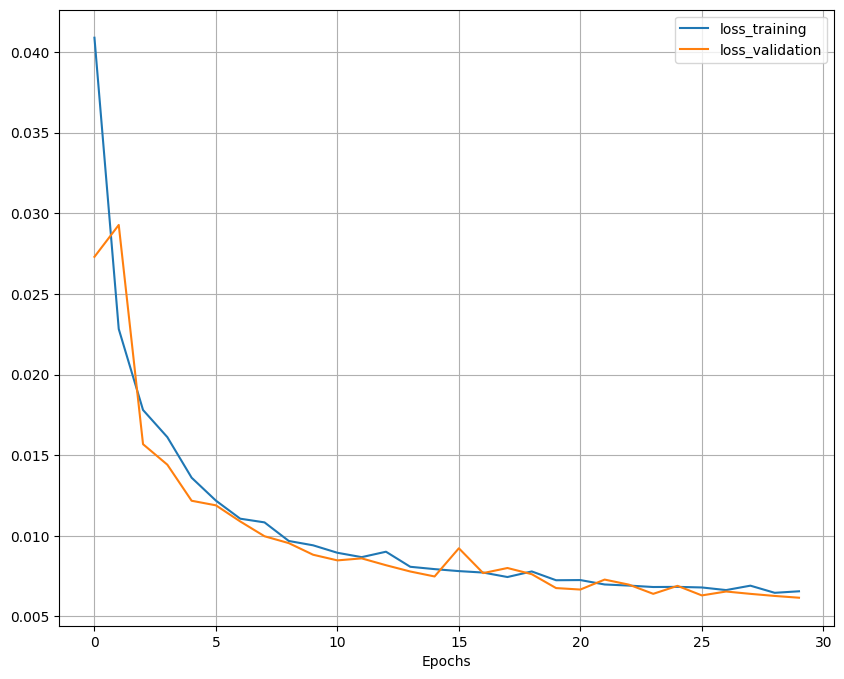

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00618211


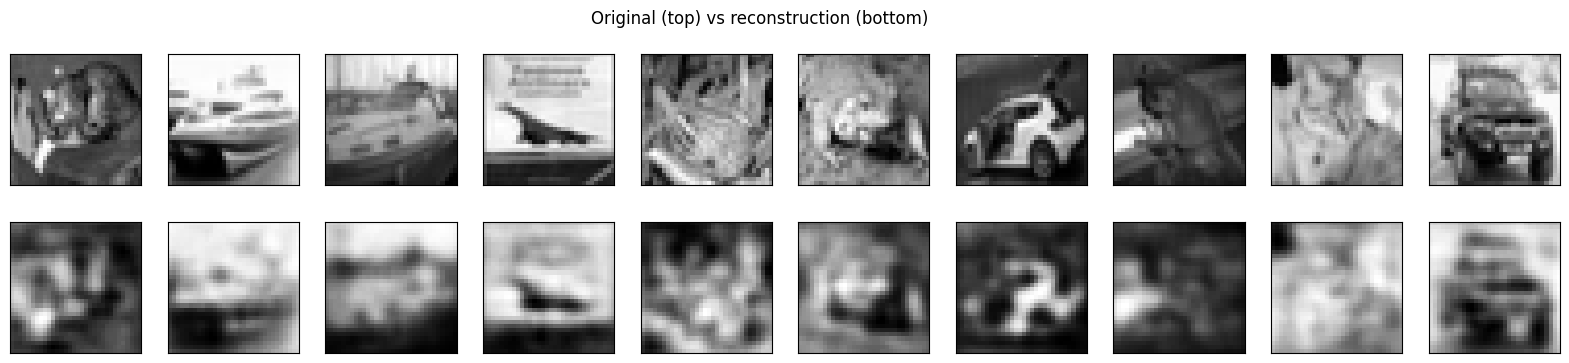

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

Before choosing different non-linear activation functions, we guess that sigmoid function and leaky relu would be better than tanh and relu. The reason that leaky relu is good is that on the positive data, it does not change the data, which mimics the behavior of linear activation function. Note that the output data range is between 0 and 1, so we expect that leaky relu would do good. But one thing that we should be aware of is that the nework is initialized using normal distribution. So, some weights are initially negative. As a result, we cannot expect leaky relu to be as good as linear. Another conclusion from this is that leaky relu is better than relu as the relu eliminates all the negative weights.

My other guess is that sigmoid will also do good. Because the data is between 0 and 1, and sigmoid in this interval can be approximated by a linear function. It also supports negative numbers which is what we want.

Now let us look at the actual results:

Activation Function| Test Loss
---|---
Linear|0.006
Sigmoid| 0.006
Leaky Relu|0.011
Tanh|0.011
Relu|0.026

As you can see, my two guesses has been confirmed. One thing I did not predict was that the tanh is as good as the leaky relu.


`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512,256] 
DEC_LAYERS = [512] 
ACT_FUN = 'sigmoid'
lr = 0.001
epochs = 45
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
│    └─Linear: 2-2                       [512, 256]                131,328
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-3                       [512, 512]                131,584
│    └─Linear: 2-4                       [512, 1024]               525,312
Total params: 1,313,024
Trainable params: 1,313,024
Non-trainable params: 0
Total mult-adds (M): 672.27
Input size (MB): 2.10
Forward/backward pass size (MB): 9.44
Params size (MB): 5.25
Estimated Total Size (MB): 16.79

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.05170874 ---------------- Val_Acc: Val_Loss: 0.03483991
epoch: 2 -> Loss: 0.02963869 ---------------- Val_Acc: Val_Loss: 0.02617743
epoch: 3 -> Loss: 0.02342661 ---------------- Val_Acc: Val_Loss: 0.02133987
epoch: 4 -> Loss: 0.01993512 ---------------- Val_Acc: Val_Loss: 0.01931389
epoch: 5 -> Loss: 0.01802720 ---------------- Val_Acc: Val_Loss: 0.01740135
epoch: 6 -> Loss: 0.01657513 ---------------- Val_Acc: Val_Loss: 0.01620525
epoch: 7 -> Loss: 0.01542254 ---------------- Val_Acc: Val_Loss: 0.01513046
epoch: 8 -> Loss: 0.01462051 ---------------- Val_Acc: Val_Loss: 0.01439157
epoch: 9 -> Loss: 0.01407831 ---------------- Val_Acc: Val_Loss: 0.01381335
epoch: 10 -> Loss: 0.01341587 ---------------- Val_Acc: Val_Loss: 0.01355466
epoch: 11 -> Loss: 0.01300053 ---------------- Val_Acc: Val_Loss: 0.01297959
epoch: 12 -> Loss: 0.01250369 ---------------- Val_Acc: Val_Loss: 0.01236095
epoch: 13 -> Loss: 0.01209598 ---------------- Val_Acc: Val_Loss: 0.01210286
epoch: 1

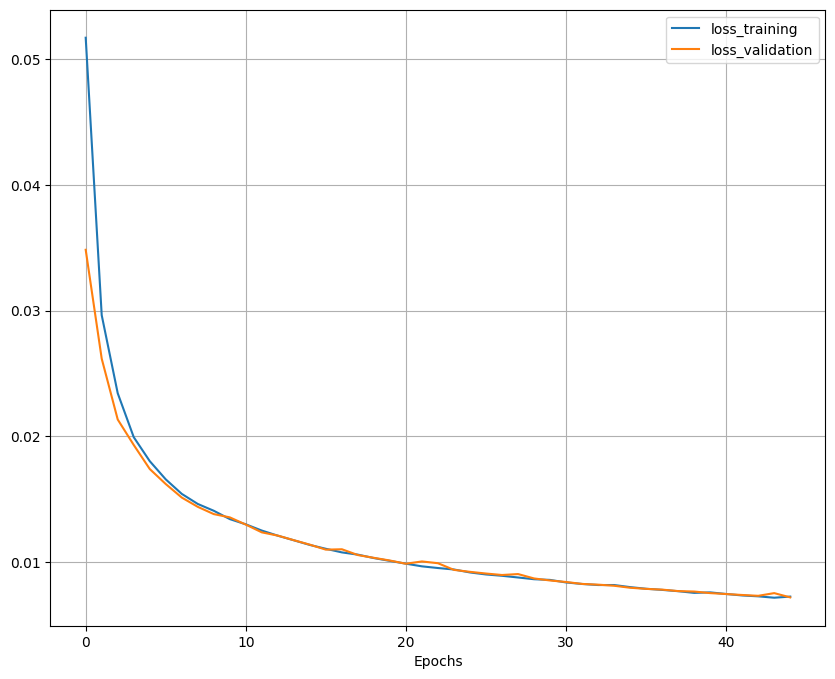

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.00713331


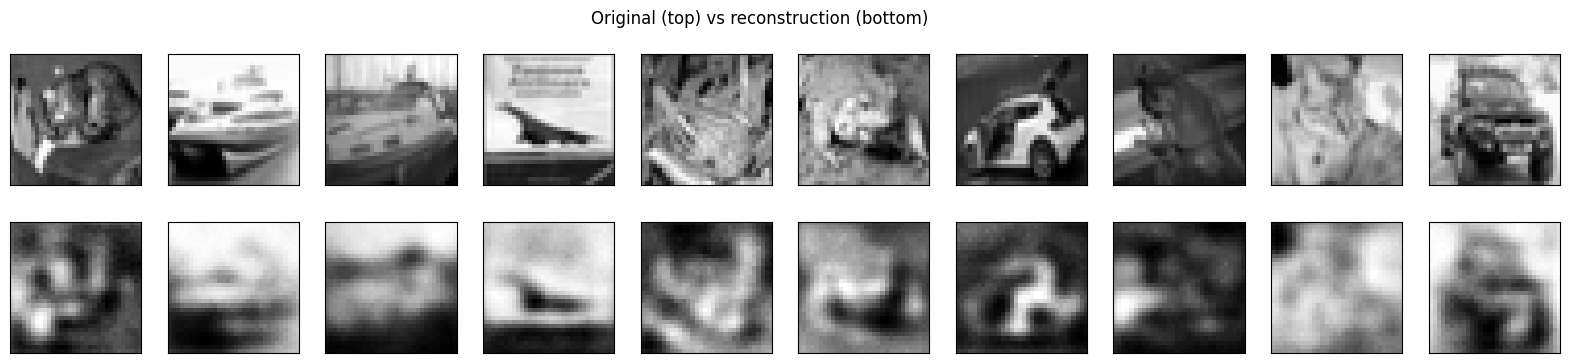

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:

In this exercise, the objective is to see whether using deeper networks can improve the results. We follow an hourglass like structure and build a encoder-decoder network. We keep the latent layer size the same as before (256) and try different hyperparameters to answer the question. Also the activation function is kept the same and it is equal to `sigmoid` function (the effect of other activation functions has been investigated in the last section).

First, let us see the result of the experiments and then we talk about them:

index|ENC_LAYERS|DEC_LAYERS|EPOCHS|learning_rate|Test Loss
---|---|---|---|---|---
1|[256]|[]|25|0.005|0.006
2|[512,256]|[512]|25|0.005|0.021
3|[512,256]|[512]|35|0.001|0.008
4|[512,256]|[512]|45|0.001|0.007
5|[1024,512,256]|[512,1024]|35|0.001|0.010

The first model, we have the shallow non-linear model for benchmarking other models. In the first deep network (model 2), using the same epochs and learning rate, the result is disappointing. We expect the deeper network to result in better or at least as good as the base model, but the test loss shows something different. My guess was that the problem is not with the model, but the model that is being trained. So, using lower learining rate and higher epochs (model 3), my guess was confirmed and the test loss is more or less the same as the shallow model.\
Looking at validation loss in the plot, we see that this can also get lower having more epochs. This suggests training the same model (model 3) with more epochs. Achieving test loss of `0.007` suggests that deeper network applied on small image of 32*32, is as good as the shallow one. One explanations is that the images are small and has few details, so a shallow network has enough parameters to learn how to embed them and deeper networks cannot improve that.\
Finally, in model 5, a deeper network is being used, having the epochs and learning rates as the model 3. It can be seen that the loss did not get better and in fact, this confirms that images are small and a shallow networks works just fine.



`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

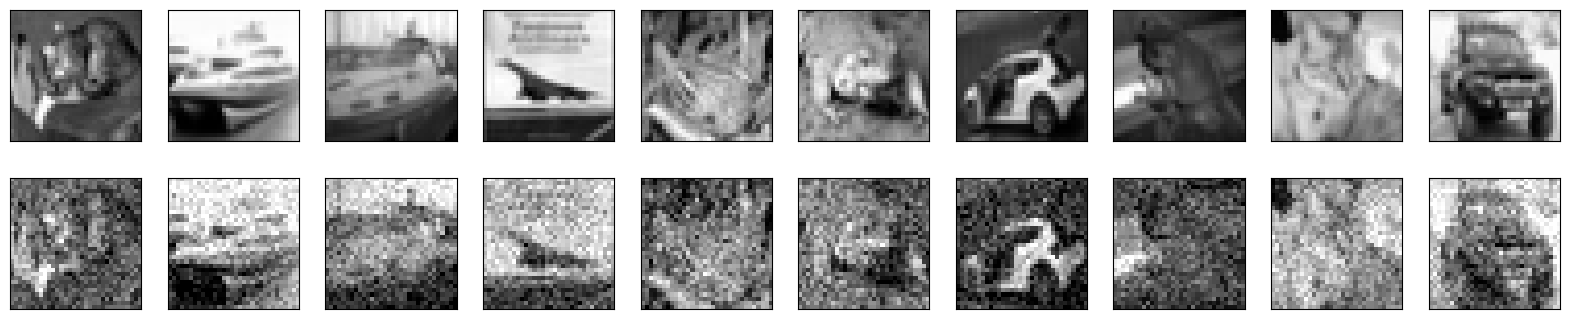

In [21]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True) #[TO COMPLETE]

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 1.45954180 ---------------- Val_Acc: Val_Loss: 0.65582758
epoch: 2 -> Loss: 0.46666279 ---------------- Val_Acc: Val_Loss: 0.32602644
epoch: 3 -> Loss: 0.24242136 ---------------- Val_Acc: Val_Loss: 0.17919084
epoch: 4 -> Loss: 0.13926144 ---------------- Val_Acc: Val_Loss: 0.10798950
epoch: 5 -> Loss: 0.08759123 ---------------- Val_Acc: Val_Loss: 0.07131105
epoch: 6 -> Loss: 0.05953579 ---------------- Val_Acc: Val_Loss: 0.05011571
epoch: 7 -> Loss: 0.04325091 ---------------- Val_Acc: Val_Loss: 0.03779775
epoch: 8 -> Loss: 0.03322189 ---------------- Val_Acc: Val_Loss: 0.02968714
epoch: 9 -> Loss: 0.02681533 ---------------- Val_Acc: Val_Loss: 0.02453970
epoch: 10 -> Loss: 0.02249638 ---------------- Val_Acc: Val_Loss: 0.02098047
epoch: 11 -> Loss: 0.02013014 ---------------- Val_Acc: Val_Loss: 0.01850626
epoch: 12 -> Loss: 0.01743286 ---------------- Val_Acc: Val_Loss: 0.01672239
epoch: 13 -> Loss: 0.01617893 ---------------- Val_Acc: Val_Loss: 0.01587457
epoch: 1

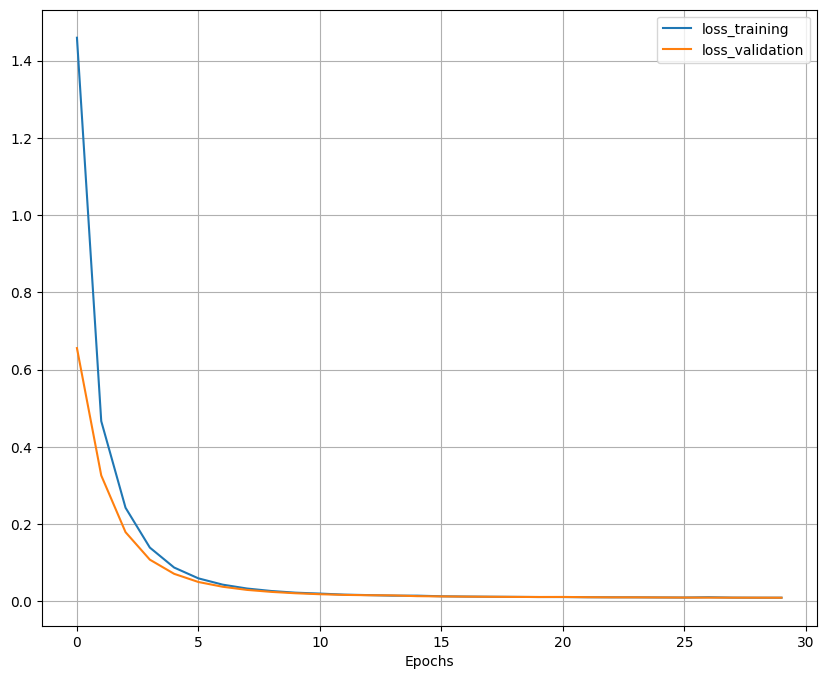

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00731809


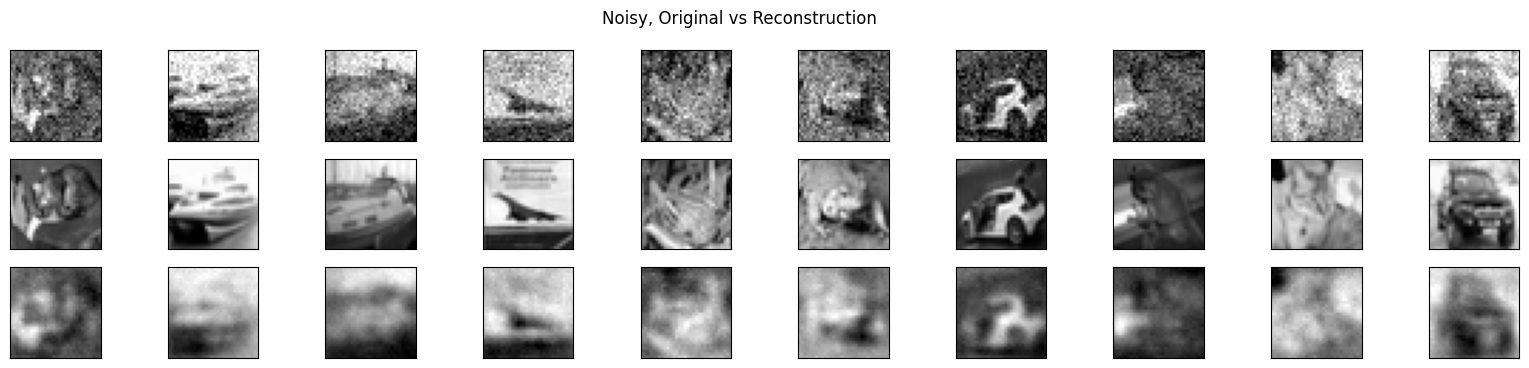

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`








**ANSWER**

For denoising task, I used pramaters like shallow linear autoencoder, that is, learning rate of 0.005, epochs of 30 and one hidden layer of size 256. Here is the result of the experiments on noise factor. Note that the effect of other hyperparameters has been investigated in the above tasks and here I only concentrate on the effect of noise factor.

index|Noise Factor|Test Loss
---|---|---
1|0.0|0.0064
2|0.1|0.0079
3|0.2|0.0073
4|0.5|0.0188

We expect that having more noise, the model would have the harder time immitating the image. This is seen in general. When the noise is very high (0.5) the test loss is three times of the not noisy model. This suggest that a little bit of noise is not very harmful for the model, but having more noise, the model struggles figuring out what is in the photo.

`%ENDTEXT`